# Intitial experiment <a class="anchor" id="intro"></a>

This notebook has two parts.

1. First, we reproduce the $AR(12)$ results from [Montero-Manso and Hyndman (2020)](https://arxiv.org/pdf/2008.00444.pdf)

2. Second, we fit a similar model to a subset of the dataset and compare this to a model fitted to the complement of the subset. The test set is the test data of the subset and the model fitted by the complement is therefore doing zero-shot forecasting.

## Table of Contents
1. [**INTRO**](#intro)
    * [Dataset](#dataset)
    * [Model](#model)
    * [Preprocessing](#preprocessing)
2. [**PART 1**](#part1)
    * [Preprocessing](#preprocessing-p1)
    * [Fitting linear and feedforward models](#fitting-models-p1)
    * [Plotting parameters, comparing to Montero-Manso and Hyndman](#plotting-parameters-p1)
    * [Forecast errors](#forecasting-p1)





## The M4 dataset <a class="anchor" id="dataset"></a>

The M4 dataset consist of 100,000 time series from a range of domains at Yearly, Quarterly, Monthly, Weekly, Daily and hourly frequencies. 

![M4 descriptive statistics](../figures/screenshots/M4Descriptive.png)

In the first part we fit the model on the full training dataset and test on the full test dataset. For the second part we select a random subset that is X% of the dataset. We fit two models, one on the subset and one on the complement, and test both on the subset partition of the test set.

## Fitting $AR(p)$ models using Ordinary Least Squares (OLS) <a class="anchor" id="model"></a>

We fit an $AR(12)$ model,
$$Y_{t} = \varphi_0 + \varphi_1 Y_{t-1} + \cdots + + \varphi_{12} Y_{t-12}.$$
This is done by OLS where we consider the last 12 values of each time series in the training set. We use 12 lags because the shortest time series in the training set has 13 observations. We can also remove the constant term as this does not seem to be part of the model considered by Montero-Manso and Hyndman (2020).

The model is fitted using the `statsmodels` package.

## Preprocessing using MASE <a class="anchor" id="preprocessingt"></a>

Montero-Manso and Hyndman (2020) suggest using MASE as forecasting metric and the scaling in MASE as a preprocessing step. MASE is defined as

$$ MASE = \underset{j \in J}{mean} \Bigg( \frac{|e_j|}{\frac{1}{T-1} \sum_{t=2}^T |Y_t-Y_{t-1}|} \Bigg) = \frac{\frac{1}{J}\sum_j |e_j|}{\frac{1}{T-1} \sum_{t=2}^T |Y_t-Y_{t-1}|}, $$

Where $t=1,\ldots,T$ are the indices of the training set and, $j=1,\ldots,J$ are the forecasts. That is, the errors are scaled by the error from a naive forecast in the training set. MASE is MAE scaled using the naive forecast.

*HOWEVER* if the time series have seasonality, we scale using the naive seasonal forecast, 

$$ MASE = \underset{j \in J}{mean} \Bigg( \frac{|e_j|}{\frac{1}{T-m} \sum_{t=m+1}^T |Y_t-Y_{t-m}|} \Bigg) = \frac{\frac{1}{J}\sum_j |e_j|}{\frac{1}{T-m} \sum_{t=m+1}^T |Y_t-Y_{t-m}|}, $$

where $m$ is the frequency of the seasonality.

We can use the scaling from MASE as a preprocessing step on our training data. On our test set we then look at the MAE as it is the same as MASE when we have scaled.

The scaling can be used in two ways:

1. Scale by using the whole training set.
2. Scale using only the last 12 values.

We provide both as a config parameter.


# Part 1 <a class="anchor" id="part1"></a>

In [2]:
import copy
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd

import statsmodels.api as sm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

np.random.seed(1729)
torch.manual_seed(1729)

import sys
sys.path.append("")
sys.path.append("../../")

In [4]:
experiments = {
    "GLOBAL" : True,
    "YEARLY" : True,
    "QUARTERLY" : True,
    "MONTHLY" : True,
    "WEEKLY" : True,
    "DAILY" : True,
    "HOURLY" : True,
}

config = {
    "MASE_SCALE" : True,
    "MASE_SCALE_SEASONALITY" : True,
    "SCALE_SET" : "FULL" # FULL or SUB. Either the all the data or just the last 12 obs.
}

# Periods used in MASE scaling
periods = {
    "YEARLY"    : 1, 
    "QUARTERLY" : 4, 
    "MONTHLY"   : 12, 
    "WEEKLY"    : 52, 
    "DAILY"     : 7, 
    "HOURLY"    : 24
}

## Preprocessing

In [6]:
datasets = {}
all_train_files = glob.glob("..\\data\\M4train\\*")
all_test_files = glob.glob("..\\data\\M4test\\*")

for experiment in experiments.keys():
    if experiments[experiment]:
        print(f"Creating datasets for experiment {experiment}.")
        if experiment == "GLOBAL":
            train_files = all_train_files
            test_files = all_test_files
        else:
            train_files = []
            test_files = []
            for f in all_train_files:
                if experiment.lower() in f.lower():
                    train_files.append(f)
            for f in all_test_files:
                if experiment.lower() in f.lower():
                    test_files.append(f)

        # Finding longest possible lag value for the dataset
        num_non_na_train = []
        num_non_na_test = []
        for train_f, test_f in zip(train_files, test_files):
            df_train = pd.read_csv(train_f, index_col=0)
            df_test = pd.read_csv(test_f, index_col=0)
            num_non_na_train.append(min(df_train.count(axis=1).values))
            num_non_na_test.append(min(df_test.count(axis=1).values))
        num_non_na_train = min(num_non_na_train)
        num_non_na_test = min(num_non_na_test)

        # Creating the dataset
        l_train = []
        l_test = []
        for train_f, test_f in zip(train_files, test_files):
            l_train_tmp = []
            l_test_tmp = []
            df_train = pd.read_csv(train_f, index_col=0)
            df_test = pd.read_csv(test_f, index_col=0)
            Y_train = df_train.to_numpy()
            Y_test = df_test.to_numpy()
            assert(Y_train.shape[0] == Y_test.shape[0])
            for i in range(Y_train.shape[0]):
                s_train = Y_train[i][~np.isnan(Y_train[i])]
                s_test = Y_test[i][~np.isnan(Y_test[i])]
                l_train_tmp.append(s_train[-num_non_na_train:]) # shortest in the train set
                l_test_tmp.append(s_test[:num_non_na_test]) # shortest in the test set

            # Scaling using the scaling in MASE
            if config["MASE_SCALE"]:
                if config["MASE_SCALE_SEASONALITY"]:
                    df_train_out = pd.DataFrame(l_train_tmp)
                    df_test_out = pd.DataFrame(l_test_tmp)
                    # Find the seasonality of the ts
                    for p in periods.keys():
                        if p.lower() in train_f.lower():
                            s = periods[p]
                    if config["SCALE_SET"] == "FULL":
                        scale = df_train.diff(periods=s,axis=1).abs().mean(axis=1).reset_index(drop=True)
                    elif config["SCALE_SET"] == "SUB":
                        scale = df_train_out.diff(periods=s,axis=1).abs().mean(axis=1).reset_index(drop=True)
                    l_train_tmp = df_train_out.div(scale, axis=0).values.tolist()
                    l_test_tmp = df_test_out.div(scale, axis=0).values.tolist()
                else:    
                    df_train_out = pd.DataFrame(l_train_tmp)
                    df_test_out = pd.DataFrame(l_test_tmp)
                    if config["SCALE_SET"] == "FULL":
                        scale = df_train.diff(axis=1).abs().mean(axis=1).reset_index(drop=True)
                    elif config["SCALE_SET"] == "SUB":
                        scale = df_train_out.diff(axis=1).abs().mean(axis=1).reset_index(drop=True)
                    l_train_tmp = df_train_out.div(scale, axis=0).values.tolist()
                    l_test_tmp = df_test_out.div(scale, axis=0).values.tolist()

            for i in range(len(l_train_tmp)):
                l_train.append(l_train_tmp[i])
                l_test.append(l_test_tmp[i])

        X_train = np.array(l_train)
        X_test = np.array(l_test)
        datasets[experiment] = (X_train, X_test)

# Check for Inf values that can occur during scaling
for d in datasets.keys():
    if len(np.argwhere(np.isinf(datasets[d][0]))) + len(np.argwhere(np.isinf(datasets[d][1]))) != 0:
        print(f"WARNING: Inf values in dataset {d}.")
        train_inf = list(set(np.argwhere(np.isinf(datasets[d][0]))[:,0]))
        X_train = np.delete(datasets[d][0], train_inf, 0)
        X_test = np.delete(datasets[d][1], train_inf, 0)
        test_inf = list(set(np.argwhere(np.isinf(X_test))[:,0]))
        X_test = np.delete(X_test, test_inf, 0)
        X_train = np.delete(X_train, test_inf, 0)
        datasets[d] = (X_train, X_test)


print("\n")
print(f"Done. Created datasets for {[d for d in datasets.keys()]}.\n")
print("Sizes of the datasets: ")
for dataset in datasets.keys():
    print(f"{dataset:9} : ({str(datasets[dataset][0].shape[0]):>6}, {str(datasets[dataset][0].shape[1]):>3}), ({datasets[dataset][1].shape[0]:>6}, {datasets[dataset][1].shape[1]:>2})")

print("\n")
for d in datasets.keys():
    if len(np.argwhere(np.isinf(datasets[d][0]))) + len(np.argwhere(np.isinf(datasets[d][1]))) != 0:
        print("Unsuccessful in removing Inf values.")
        print(f"WARNING: Inf values in dataset {d}.")

Creating datasets for experiment GLOBAL.
Creating datasets for experiment YEARLY.
Creating datasets for experiment QUARTERLY.
Creating datasets for experiment MONTHLY.
Creating datasets for experiment WEEKLY.
Creating datasets for experiment DAILY.
Creating datasets for experiment HOURLY.


Done. Created datasets for ['GLOBAL', 'YEARLY', 'QUARTERLY', 'MONTHLY', 'WEEKLY', 'DAILY', 'HOURLY'].

Sizes of the datasets: 
GLOBAL    : (100000,  13), (100000,  6)
YEARLY    : ( 23000,  13), ( 23000,  6)
QUARTERLY : ( 24000,  16), ( 24000,  8)
MONTHLY   : ( 48000,  42), ( 48000, 18)
WEEKLY    : (   359,  80), (   359, 13)
DAILY     : (  4227,  93), (  4227, 14)
HOURLY    : (   414, 700), (   414, 48)




## Fitting models <a class="anchor" id="fitting-models-p1"></a>

### AR(p)

In [8]:
models = {}
for i, dataset in enumerate(datasets.keys()):
    X_train = copy.deepcopy(datasets[dataset][0])
    Y = X_train[:,-1]
    X = X_train[:,:-1]
    # vv This is the constant term \varphi_0
    #X = sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    print(f"{dataset:9} : {len(results.params)}")
    models[dataset] = results

GLOBAL    : 12
YEARLY    : 12
QUARTERLY : 15
MONTHLY   : 41
WEEKLY    : 79
DAILY     : 92
HOURLY    : 699


### Forecast

In [10]:
forecasts = {}
mase = {}

for model in models.keys():
    print(model)
    # forecast
    mod = models[model]
    X_train = copy.deepcopy(datasets[model][0])
    X_test = copy.deepcopy(datasets[model][1])
    Y_hat = []
    for i in range(X_test.shape[1]):
        if i == 0:
            X = X_train[:,i+1:]
        else:
            X = np.concatenate((X_train[:,(i+1):], X_test[:,:i]), axis=1)
        assert X.shape[1] == len(mod.params)
        Y_hat.append(mod.predict(X))

    forecasts[model] = np.stack(Y_hat, axis=1)

    # calculate mase (mae since we have already scaled)
    error = np.mean(np.abs(forecasts[model] - X_test))
    mase[model] = error

df = pd.DataFrame({"Model": [e for e in experiments.keys() if experiments[e]], "MASE": [m for m in mase.values()]})
print(df.head(10))

GLOBAL
YEARLY
QUARTERLY
MONTHLY
WEEKLY
DAILY
HOURLY
       Model      MASE
0     GLOBAL  0.855099
1     YEARLY  1.375822
2  QUARTERLY  0.689132
3    MONTHLY  0.509179
4     WEEKLY  0.544223
5      DAILY  0.444453
6     HOURLY  0.952328


## Plotting  parameters and comparing to Montero-Manso and Hyndman <a class="anchor" id="plotting-parameters-p1"></a>

(0.0, 13.0)

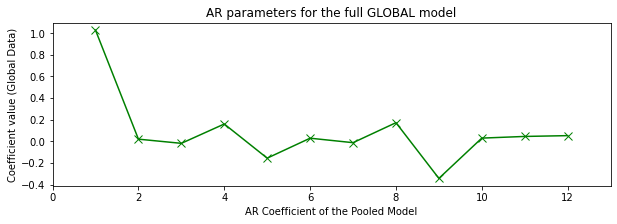

In [12]:
fig, axs = plt.subplots(nrows=3, figsize=(10,10))

axs[0].plot([i+1 for i in range(len(models["YEARLY"].params[::-1]))], models["YEARLY"].params[::-1], marker="x", markersize=8, color="g")
axs[0].set_xlabel("AR Coefficient of the Pooled Model")
axs[0].set_ylabel("Coefficient value (Yearly Data)")
axs[0].set_xlim((0,13))

axs[1].plot([i+1 for i in range(len(models["QUARTERLY"].params[::-1]))], models["QUARTERLY"].params[::-1], marker="x", markersize=8, color="g")
axs[1].set_xlabel("AR Coefficient of the Pooled Model")
axs[1].set_ylabel("Coefficient value (Quarterly Data)")
axs[1].set_xlim((0,22))

axs[2].plot([i+1 for i in range(len(models["MONTHLY"].params[::-1]))], models["MONTHLY"].params[::-1], marker="x", markersize=8, color="g")
axs[2].set_xlabel("AR Coefficient of the Pooled Model")
axs[2].set_ylabel("Coefficient value (Monthly Data)")
axs[2].set_xlim((0,70))

plt.tight_layout()
plt.savefig("../figures/ARCoefficients.jpg")
plt.close("all")

plt.figure(figsize=(10,3))
plt.plot([i+1 for i in range(len(models["GLOBAL"].params[::-1]))], models["GLOBAL"].params[::-1], marker="x", markersize=8, color="g")
plt.title("AR parameters for the full GLOBAL model")
plt.xlabel("AR Coefficient of the Pooled Model")
plt.ylabel("Coefficient value (Global Data)")
plt.xlim((0,13))

### Below are coefficients of AR models from Montero-Manso and Hyndman (2020) (left) and our experimets (right). The coefficient from the M4 are shown as green crosses.
The parameters are not exacly the same, but follow the same patterns. It is not clear what causes the differences. Scaling using seasonal MASE makes the parameters closer to Monter-Manso and Hyndman than using the non-seasonal one.


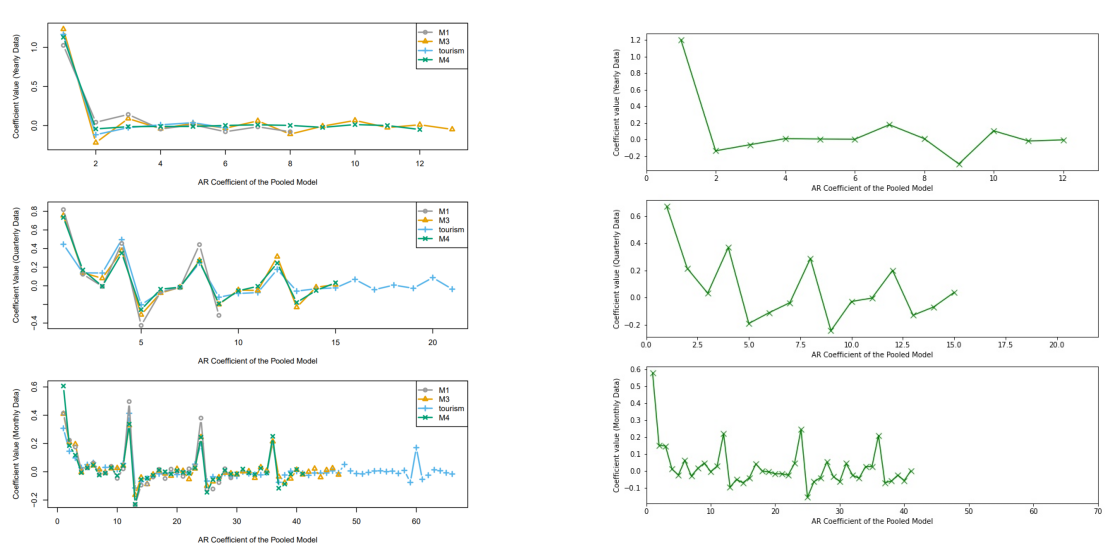

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,10))

axs[0].imshow(mpimg.imread("../figures/screenshots/HyndmanARCoefficients.png"))
axs[0].axis('off')

axs[1].imshow(mpimg.imread("../figures/ARCoefficients.jpg"))
axs[1].axis('off')
plt.show()

## Results and model parameters

### Experiment showing MASE as a function of dataset size

In [ ]:
datasets = {}
all_train_files = glob.glob("..\\data\\M4train\\*")
all_test_files = glob.glob("..\\data\\M4test\\*")
for experiment in experiments.keys():
    if experiments[experiment]:
        print(f"Creating datasets for experiment {experiment}.")
        if experiment == "GLOBAL":
            train_files = all_train_files
            test_files = all_test_files
        else:
            train_files = []
            test_files = []
            for f in all_train_files:
                if experiment.lower() in f.lower():
                    train_files.append(f)
            for f in all_test_files:
                if experiment.lower() in f.lower():
                    test_files.append(f)
        l = []
        for f in train_files:
            Y = pd.read_csv(f, index_col=0).to_numpy()
            
            for i in range(Y.shape[0]):
                s = Y[i][~np.isnan(Y[i])]
                l.append(s[-13:]) # shortest in the train set
        X_train = np.array(l)

        l = []
        for f in test_files:
            Y = pd.read_csv(f, index_col=0).to_numpy()
            for i in range(Y.shape[0]):
                s = Y[i][~np.isnan(Y[i])]
                l.append(s[:6]) # shortest in the test set
        X_test = np.array(l)

        datasets[experiment] = (X_train, X_test)
print(f"Done. Created datasets for {[d for d in datasets.keys()]}.")

In [15]:
fig, axs = plt.subplots(nrows=int((len(datasets)+1)/2), ncols=2, figsize=(10, 10))
axs[int(i/2), i%2].plot([i+1 for i in range(len(results.params[::-1]))], results.params[::-1], marker="x")
axs[int(i/2), i%2].set_title(f"Lag parameter values of {dataset} model")
axs[int(i/2), i%2].set_xlabel("AR coefficient of model")
axs[int(i/2), i%2].set_ylabel("Coefficient value")
axs[int(i/2), i%2].set_xticks([i+1 for i in range(len(results.params[::-1]))])
axs[int(i/2), i%2].grid()
plt.tight_layout()
plt.show()


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed